# Predicting Used Car Prices

Suppose we have the following problem:

> Tom wants to sell his car, but doesn't know how much he should sell it for. He wants to sell it for as much as possible, but also have it be reasonably priced so someone would want to purchase it. How can we help Tom determine the best price for the car?

In short: `Can we estimate the price of a used car based on its characteristics?`.

### Data Source

The data can be found at: https://archive.ics.uci.edu/dataset/10/automobile
- We can view the data contents (excludes headers) at: https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data

### Table of Contents:

- [0. Prerequisites](#0.-Prerequisites)
- [1. Reading the Cleaned Data](#1.-Reading-the-Cleaned-Data)
- [2. Training & Testing](#2.-Training-&-Testing)
  - [2.1 Training & Testing with Linear Regression](#2.1-Training-&-Testing-with-Linear-Regression)
  - [2.2 Cross-Validation Score](#2.2-Cross-Validation-Score)
- [3. Overfitting, Underfitting, and Model Selection](#3.-Overfitting,-Underfitting,-and-Model-Selection)
  - [3.1 Ridge Regression](#3.1-Ridge-Regression)
  - [3.2 Grid Search](#3.2-Grid-Search)

<hr />

# 0. Prerequisites

Before you run this notebook, complete the following steps:
- Install Libraries/Packages
- Import Required Modules


### Install Libraries/Packages

This will install all of the libraries/packages used in all of the notebooks for this project.

In [ ]:
! pip install pandas numpy scipy matplotlib seaborn scikit-learn

### Import Required Modules

Import and configure the required modules.

In [138]:
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, train_test_split
from tqdm import tqdm

# 1. Reading the Cleaned Data

We start off by reading the cleaned dataset, displaying the first 5 rows, and then taking a look at the inferred columns and column types.

In [77]:
# Define file location.
DATA_PATH = "./automobile_cleaned.csv"
# Use pandas to read the data.
cleaned_data = pd.read_csv(DATA_PATH)
# Display the first 5 rows.
cleaned_data.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,122,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,122,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,122,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [78]:
cleaned_data.dtypes

symboling              int64
normalized-losses      int64
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                 float64
stroke               float64
compression-ratio    float64
horsepower           float64
peak-rpm             float64
city-mpg               int64
highway-mpg            int64
price                float64
dtype: object

# 2. Training & Testing

An important step for testing our model is to split our data into training & testing sets. By doing so, we can see how well our model can perform with unseen data.

To do this, we need to:
- Extract the dependent variable from the training data.
- Drop the dependent variable from the training data.
- Split the data into training & tesing groups.

In [79]:
# Extract & drop dependent variable from data set.
y_data = cleaned_data["price"]
x_data = cleaned_data.drop("price", axis=1)
# Split the data into training & testing sets.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=1)
print(f"Number of Training Samples: {x_train.shape[0]}")
print(f"Number of Testing Samples: {x_test.shape[0]}")

Number of Training Samples: 180
Number of Testing Samples: 21


### 2.1 Training & Testing with Linear Regression

Let's modify the `createLRModel` to support training & testing data.

In [86]:
def createLRModel(independent_variables: List[str], test_size=0.3, random_state=1):
  """
  Creates a Linear Regression model which predicts the `price` from the
  provided independent variables. Works with both Simple & Multiple Linear
  Regression.
  """
  # Create Linear Regression object.
  lre = LinearRegression()
  # Get the values for the independent & dependent variables.
  X = cleaned_data[independent_variables]
  Y = cleaned_data["price"]
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
  # Fit/train the model.
  lre.fit(x_train, y_train)
  # Predict values.
  Yhat = lre.predict(x_train)
  # Generate the resulting linear equation.
  eq = f"y = {lre.intercept_}{"".join([f" + ({lre.coef_[i]} * {ind_var})" for i, ind_var in enumerate(independent_variables)])}"
  return (lre, x_train, x_test, y_train, y_test, Yhat, eq)

def analyzeLRModel(independent_variables: List[str], test_size=0.3, random_state=1, n=5):
  """
  Prints out the equation from creating a Linear Regression model from
  independent variables and displays the first `n` rows comparing the
  predicted and actual results.
  """
  lrInfo = createLRModel(independent_variables, test_size=test_size, random_state=random_state)
  y_train, Yhat, eq = lrInfo[3], lrInfo[5], lrInfo[6]
  # Print linear equation representing Linear Regression model.
  print(eq)
  # Compare the predicted results with the actual values.
  comparison = pd.DataFrame({
    **{ ind_var: cleaned_data[ind_var] for ind_var in independent_variables }, # Unpack dictionary
    "price": y_train,
    "predicted-price": Yhat,
    "price-difference": y_train - Yhat
  })
  with pd.option_context("display.max_columns", None, "display.width", 1000):
    print(comparison[:n])

Now let's create a Linear Regression model for the `horsepower` feature and see the difference in performance with the training set and testing set.

In [90]:
# Allow us to dynamically change the independent variable used.
ind_variable = "horsepower"

lrInfo = createLRModel([ind_variable], test_size=0.1)
lre, x_train, x_test, y_train, y_test = lrInfo[:5]

print(x_train.shape, x_test.shape)

print(f"The R-square for the training data is: {lre.score(x_train, y_train)}")
print(f"The R-square for the testing data is: {lre.score(x_test, y_test)}")

(180, 1) (21, 1)
The R-square for the training data is: 0.6621588065210514
The R-square for the testing data is: 0.3634554596325087


As we can see, the R^2 value on our testing set is much lower compared to our training set.

Sometimes, we don't have sufficient testing data, in which, we may look to cross-validation.

### 2.2 Cross-Validation Score

Cross Validation evenly splits the data and tries all combinations of training and testing groups, returning an array of R-squared scores.

Lets try this on the `horsepower` example with 4 folds.

In [95]:
Rcross = cross_val_score(LinearRegression(), cleaned_data[["horsepower"]], cleaned_data["price"], cv=4)
print(f"R-squared Scores Obtained: {Rcross}")
print(f"Cross Validation Score: {Rcross.mean()}")
print(f"Standard Deviation of folds: {Rcross.std()}")

R-squared Scores Obtained: [0.7747254  0.51722436 0.74881624 0.04792707]
Cross Validation Score: 0.5221732664777984
Standard Deviation of folds: 0.29158341973020163


We can also predict the outputs using `cross_val_predict`.

In [96]:
Yhat = cross_val_predict(LinearRegression(), cleaned_data[["horsepower"]], cleaned_data["price"], cv=4)
Yhat[:5]

array([14143.6442164 , 14143.6442164 , 20817.63619486, 12746.7621744 ,
       14764.48067952])

# 3. Overfitting, Underfitting, and Model Selection

**Underfitting** is when the model is too simple to fit the data. **Overfitting** is when the model is too flexible and fits the noise rather than the function.

We'll explore whether the models we've created are overfitting or underfitting by creating a MLR model from the `horsepower`, `curb-weight`, `engine-size`, and `highway-mpg` features.

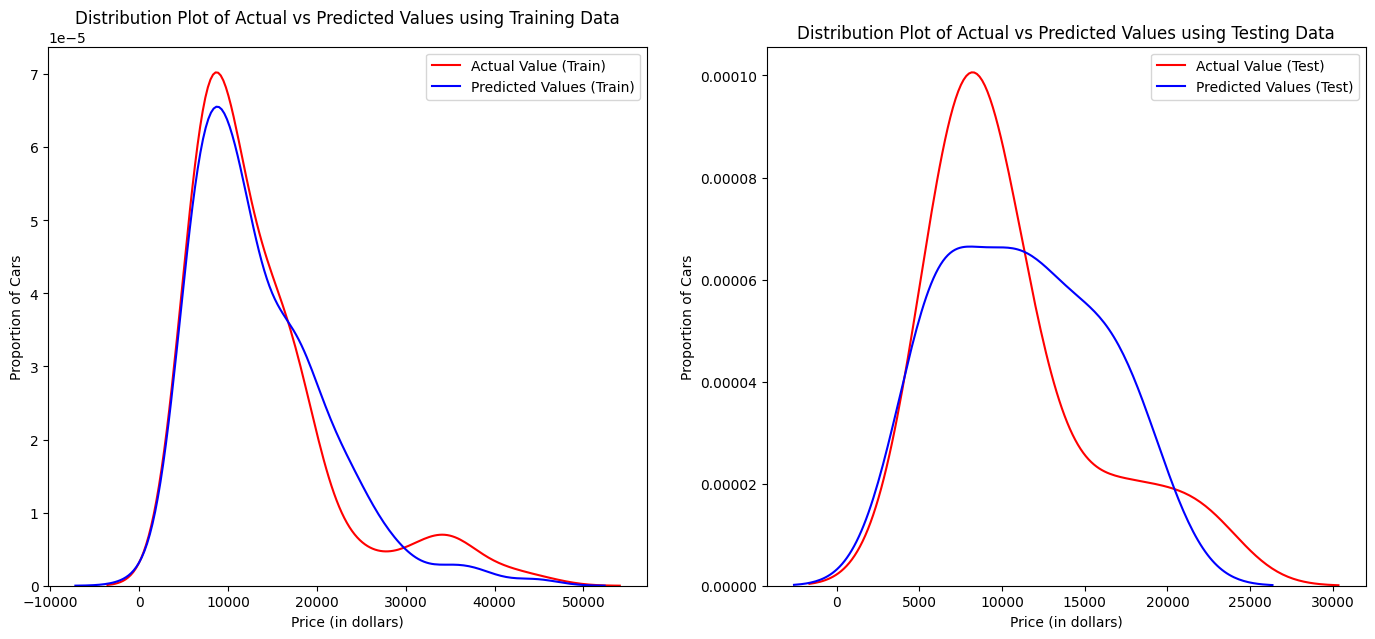

In [124]:
# Allow us to dynamically change the independent variables used.
ind_variables = ["horsepower", "curb-weight", "engine-size", "highway-mpg"]

lre, x_train, x_test, y_train, y_test = createLRModel(ind_variables, test_size=0.1)[:5]

# Get predicted values for our training & testing data.
Yhat_train = lre.predict(x_train)
Yhat_test = lre.predict(x_test)

# Plot differences
fig, axs = plt.subplots(ncols=2, figsize=(17,7))

# Plot comparing training data.
ax_train = sns.kdeplot(y_train, color="r", label="Actual Value (Train)", ax=axs[0])
sns.kdeplot(Yhat_train, color="b", label="Predicted Values (Train)", ax=ax_train)

# Plot comparing testing data.
ax_test = sns.kdeplot(y_test, color="r", label="Actual Value (Test)", ax=axs[1])
sns.kdeplot(Yhat_test, color="b", label="Predicted Values (Test)", ax=ax_test)

axs[0].set(
  title="Distribution Plot of Actual vs Predicted Values using Training Data",
  xlabel="Price (in dollars)",
  ylabel="Proportion of Cars"
  )
axs[0].legend()

axs[1].set(
  title="Distribution Plot of Actual vs Predicted Values using Testing Data",
  xlabel="Price (in dollars)",
  ylabel="Proportion of Cars"
  )
axs[1].legend()

plt.show()
plt.close()

We can observe that the model fits the training data pretty well, however, with the testing data set, it performs poorly.

### 3.1 Ridge Regression

Ridge Regression is a method of preventing overfitting by introducing a new parameter, *alpha* from cross validation.

Let's try this out on the `horsepower`, `curb-weight`, `engine-size`, `highway-mpg`, `normalized-losses`, and `symboling` features.

In [133]:
# Functions from 5th Lab from IBM SkillsBuild's "Data Analysis with Python"

def PollyPlot(xtrain, xtest, y_train, y_test, lr,poly_transform):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))
    
    
    #training data 
    #testing data 
    # lr:  linear regression object 
    #poly_transform:  polynomial transformation object 
 
    xmax=max([xtrain.values.max(), xtest.values.max()])

    xmin=min([xtrain.values.min(), xtest.values.min()])

    x=np.arange(xmin, xmax, 0.1)


    plt.plot(xtrain, y_train, 'ro', label='Training Data')
    plt.plot(xtest, y_test, 'go', label='Test Data')
    plt.plot(x, lr.predict(poly_transform.fit_transform(x.reshape(-1, 1))), label='Predicted Function')
    plt.ylim([-10000, 60000])
    plt.ylabel('Price')
    plt.legend()

In [134]:
# Extract & drop dependent variable from data set.
y_data = cleaned_data["price"]
x_data = cleaned_data.drop("price", axis=1)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.45, random_state=0)

# Create Polynomial Featuers object.
pr = PolynomialFeatures(degree=2)
x_train_pr = pr.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg','normalized-losses','symboling']])
x_test_pr = pr.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg','normalized-losses','symboling']])

We'll test the Ridge Regression model using an alpha value of 1:

In [ ]:
# Create Ridge Regression model.
RigeModel = Ridge(alpha=1)
# Fit/train the model.
RigeModel.fit(x_train_pr, y_train)
# Predict using test data.
Yhat = RigeModel.predict(x_test_pr)

# Compare predicted results with test values.
print('predicted:', Yhat[0:4])
print('test set :', y_test[0:4].values)

We'll now test a range of alpha values and then create a plot comparing the R^2 values for different alpha values.

100%|██████████| 1000/1000 [00:02<00:00, 391.39it/s, Test Score=0.564, Train Score=0.859]


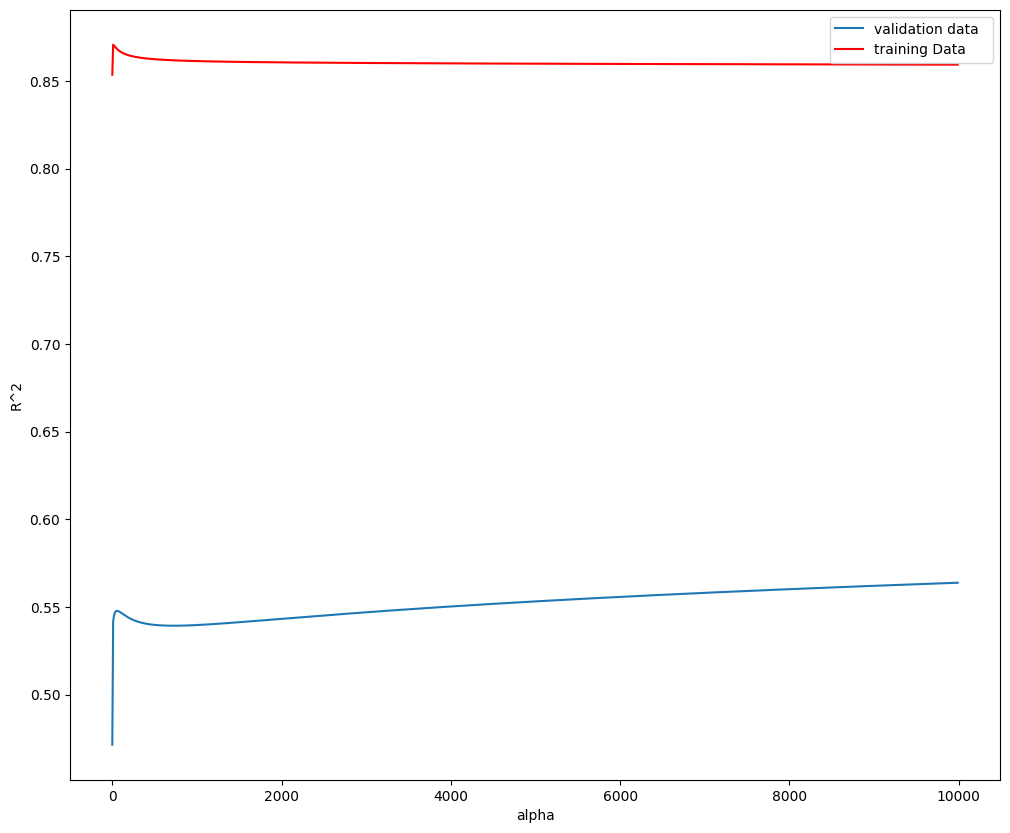

In [137]:
# Create Ridge Regression model on a range of alpha values.
Rsqu_test = []
Rsqu_train = []
dummy1 = []
Alpha = 10 * np.array(range(0,1000))
pbar = tqdm(Alpha)

for alpha in pbar:
    RigeModel = Ridge(alpha=alpha) 
    RigeModel.fit(x_train_pr, y_train)
    test_score, train_score = RigeModel.score(x_test_pr, y_test), RigeModel.score(x_train_pr, y_train)
    
    pbar.set_postfix({"Test Score": test_score, "Train Score": train_score})

    Rsqu_test.append(test_score)
    Rsqu_train.append(train_score)

# Plot the difference between R^2 values for the training & validation (testing) data
# across the range of alpha values.
width = 12
height = 10
plt.figure(figsize=(width, height))

plt.plot(Alpha,Rsqu_test, label='validation data  ')
plt.plot(Alpha,Rsqu_train, 'r', label='training Data ')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend()

For the training data, we notice that as alpha increases:
- R^2 decreases.
- The model performance on training data worsens.

For the validation (testing) data, we notice that as alpha increases:
- R^2 increases and converges to a point.

### 3.2 Grid Search

The term alpha used in the Ridge Regression model is considered a hyperparameter. We can use Grid Search to make the process of finding the best hyperparameter simpler.

In [145]:
# Create a dictionary of parameter values.
parameters1= [{ "alpha": [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000] }]
# Create a Ridge Regression object.
RR = Ridge()
# Create a Ridge Grid Search object.
Grid1 = GridSearchCV(RR, parameters1, cv=4)
# Fit/train the model.
Grid1.fit(x_data[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_data)
# Get the best estimator (ie: best alpha value).
BestRR = Grid1.best_estimator_
print(f"Best alpha value: {BestRR.alpha}")
# Test the model, returning the R^2 value.
print(f"Best R^2 value: {BestRR.score(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_test)}")

Best alpha value: 10000
Best R^2 value: 0.8412088001897692


We can observe that Grid Search determined that an alpha value of 10000 produced the best results, resulting in an R^2 value of ~84.121%.